In [1]:
%reload_ext autoreload
%autoreload 2

The following example was taken from Reddy (2005) "An introduction to non-linear finite element analysis" Section 9.4.5.

Here we present numerical results obtained for a cantilevered rectangular plate of length a = 10 in, height b = 1 in, and thickness h = 0:1 in, and subjected to uniformly distributed in-plane load ty = -q0 psi, acting downward, along its length. The material of the plate has a modulus ofE = 1.2E7 psi and Poisson's ratio of nu = 0.3.

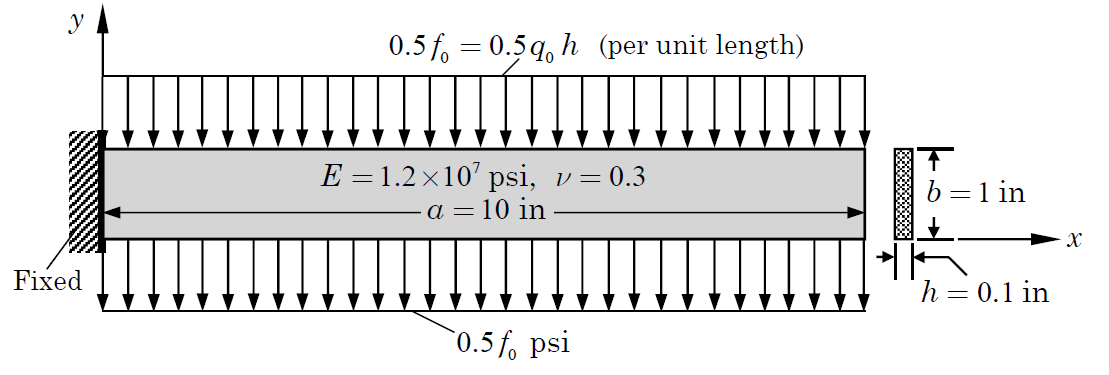

### General Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt

### Mesh definition

In [3]:
from mesh_utils import UniformQuadMesh2D

lx = 10                 # Dimension along x-coord
ly = 1                  # Dimension along y-coord
nx = 4                  # Number of elements along x-coord
ny = 1                  # Number of elements along y-coord
element_type = 'Q4'     # Type of elements

cantilever_mesh = UniformQuadMesh2D(lx, ly, nx, ny, element_type=element_type)
cantilever_mesh.compute()

formulation = 'TLF'  # 'infinitesimal', 'TLF'

In [4]:
print(f'\nNodal coordinates:\n {cantilever_mesh.coordinates}')
print(f'\nElement connectivity:\n {cantilever_mesh.elements}')

print(f'\nNumber of nodes: {cantilever_mesh.nnod}')
print(f'Number of elements: {cantilever_mesh.nelem}')


Nodal coordinates:
 [[ 0.   0. ]
 [ 2.5  0. ]
 [ 5.   0. ]
 [ 7.5  0. ]
 [10.   0. ]
 [ 0.   1. ]
 [ 2.5  1. ]
 [ 5.   1. ]
 [ 7.5  1. ]
 [10.   1. ]]

Element connectivity:
 {'quad': [array([7, 6, 1, 2]), array([8, 7, 2, 3]), array([9, 8, 3, 4]), array([10,  9,  4,  5])]}

Number of nodes: 10
Number of elements: 4


In [5]:
cantilever_mesh.node_groups

{'all': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'bottom': [1, 2, 3, 4, 5],
 'top': [6, 7, 8, 9, 10],
 'left': [1, 6],
 'right': [5, 10]}

In [6]:
cantilever_mesh.element_groups

{'all': [1, 2, 3, 4],
 'bottom': [1, 2, 3, 4],
 'top': [1, 2, 3, 4],
 'left': [1],
 'right': [4]}

### Dirichlet boundary conditions

In [7]:
from feinn_solver import BoundaryCondition

cantilever_bc = {
                'left': [BoundaryCondition(dof=1, value=0.0),
                        BoundaryCondition(dof=2, value=0.0)]
                }

### Define material

In [8]:
from matmodels import LinearElasticPlaneStress

dummy_mat = LinearElasticPlaneStress(EMOD = 1.2*1e7, nu = 0.20)

cantilever_matfld = {'all': dummy_mat}

### von Neumman boundary conditions

In [9]:
from feinn_solver import EdgeLoad

cantilever_edge_loads = {
                        'top': EdgeLoad(side = 1, ftangential = 0.0, fnormal = -450, reference = "global"),
                        'bottom': EdgeLoad(side = 3, ftangential = 0.0, fnormal = -450, reference = "global"),
                        }

### Model

In [10]:
from feinn_solver import NFEA

cantilever_fem = NFEA(mesh = cantilever_mesh, 
                      bcs = cantilever_bc, 
                      matfld = cantilever_matfld,
                      edge_loads = cantilever_edge_loads,
                      verbose = True
                      )

[matfld] Assigned: ['all']
[matfld] All 4 elements have assigned material
[edge_load] Applied 2 edge load groups
[BC] Processed 2 Dirichlet condition(s) → 4 total constraint(s)
[BC] Applied Dirichlet BCs → 4 fixed DOFs


In [11]:
# assign thickness to elements
for elem_i in cantilever_fem.elements:
    elem_i.thickness = 0.1

In [12]:
cantilever_fem.Fext_total

tensor([    0.0000,  -562.5000,     0.0000, -1125.0000,     0.0000, -1125.0000,
            0.0000, -1125.0000,     0.0000,  -562.5000,     0.0000,  -562.5000,
            0.0000, -1125.0000,     0.0000, -1125.0000,     0.0000, -1125.0000,
            0.0000,  -562.5000])

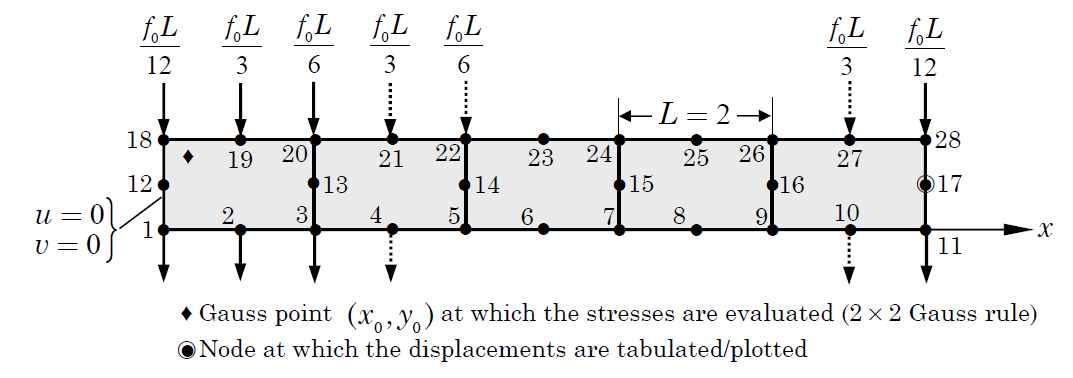

In [13]:
cantilever_fem.formulation = formulation
cantilever_fem.run_complete(nsteps=1)

[Load] Set load factor = 1.0000.
Iter   1 | du error: 1.00e+00  Res error: 2.37e+02  Energetic error: -2.46e+05
Iter   2 | du error: 1.58e-01  Res error: 2.05e+01  Energetic error: 9.90e+03
Iter   3 | du error: 1.62e-02  Res error: 2.39e-01  Energetic error: 1.28e+01
Iter   4 | du error: 2.69e-03  Res error: 1.44e-03  Energetic error: 2.29e-03
Iter   5 | du error: 5.55e-05  Res error: 8.08e-07  Energetic error: 8.26e-09
Iter   6 | du error: 8.08e-09  Res error: 5.47e-13  Energetic error: 7.19e-19
Converged in 6 iterations


In [14]:
cantilever_fem.udisp

tensor([ 0.0000,  0.0000, -0.1394, -0.3145, -0.3054, -1.0348, -0.4990, -1.9463,
        -0.6985, -2.9158,  0.0000,  0.0000,  0.0893, -0.3386,  0.0353, -1.0948,
        -0.1167, -2.0223, -0.3080, -2.9953])

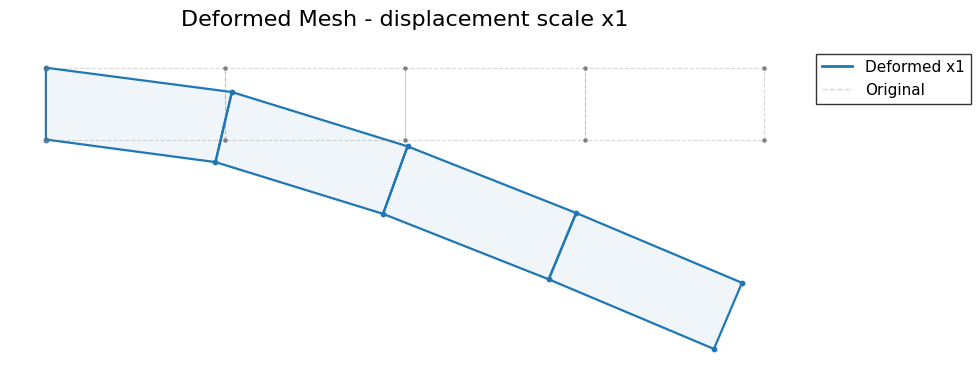

In [15]:
cantilever_fem.plot_deformed_mesh(scale=1)

In [16]:
Fint_fem = cantilever_fem._assemble_internal_forces(cantilever_fem.udisp)
Fint_fem

tensor([ 4.3381e+04,  4.2853e+03, -5.4570e-11, -1.1250e+03, -1.4734e-10,
        -1.1250e+03, -2.1737e-10, -1.1250e+03, -1.2257e-10, -5.6250e+02,
        -4.3381e+04,  3.5897e+03,  1.1642e-10, -1.1250e+03,  3.0923e-11,
        -1.1250e+03,  3.6471e-10, -1.1250e+03,  1.2380e-10, -5.6250e+02])

In [17]:
from feinn_solver import FEINN
from nn_models import mFCNet, FCResNet
import torch.nn as nn

feinn_solver = FEINN(
    mesh=cantilever_mesh,
    bcs=cantilever_bc,
    matfld=cantilever_matfld,
    edge_loads=cantilever_edge_loads,
    verbose=False,
    nnet = mFCNet(),
    bc_weight=1e6,
    nnet_init = 'xavier',
    )

feinn_solver.formulation = formulation

# assign thickness to elements
for elem_i in feinn_solver.elements:
    elem_i.thickness = 0.1

In [18]:
from types import SimpleNamespace

cfg = SimpleNamespace(**{})

cfg.epochs = 0
cfg.learning_rate = 1e-2
cfg.lr_min = 1e-5

In [33]:
import torch

optimizer = torch.optim.Adam(
    feinn_solver.nnet.parameters(),
    lr = cfg.learning_rate,
    weight_decay = 0,
  )

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max = cfg.epochs,
    eta_min = cfg.lr_min
  )

# Entrenar
feinn_solver.train(epochs = cfg.epochs, 
                   optimizer = optimizer, 
                   scheduler = scheduler,
                   lbfgs_epochs = 100,
                   warmup = True, 
                   verbose = True)

[FEINN] Starting warmup for zero initial displacement
[FEINN] Warmup completado - salida inicial ≈ 0
[FEINN] Zero-output init: max |u| inicial = 1.57e-02

Epoch 1/100 (L-BFGS)
Total Loss: 5.000e+02
  Domain: 1.197e+01
  BC:     8.241e+00

Epoch 50/100 (L-BFGS)
Total Loss: 1.560e-10
  Domain: 1.249e-10
  BC:     3.111e-11

Epoch 100/100 (L-BFGS)
Total Loss: 1.560e-10
  Domain: 1.249e-10
  BC:     3.111e-11


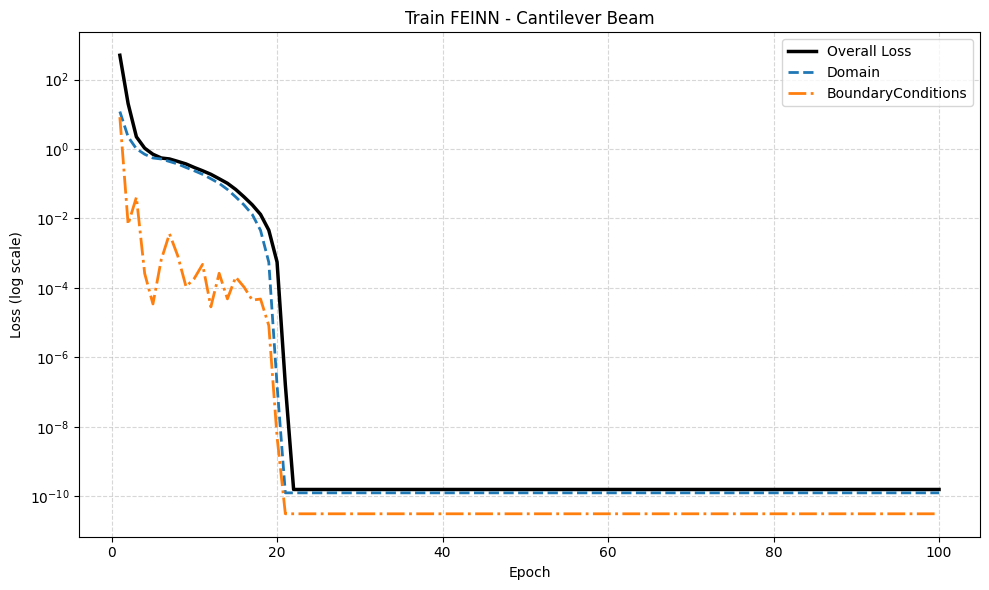

In [34]:
feinn_solver.plot_history(title="Train FEINN - Cantilever Beam")

In [35]:
cantilever_fem.udisp/feinn_solver.udisp

tensor([0.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, -0.0000, -0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000])

In [36]:
feinn_solver.udisp

tensor([ 9.5942e-09,  7.1090e-10, -1.3939e-01, -3.1449e-01, -3.0541e-01,
        -1.0348e+00, -4.9902e-01, -1.9463e+00, -6.9851e-01, -2.9158e+00,
        -1.1342e-09, -5.5335e-09,  8.9266e-02, -3.3861e-01,  3.5256e-02,
        -1.0948e+00, -1.1668e-01, -2.0223e+00, -3.0800e-01, -2.9953e+00])

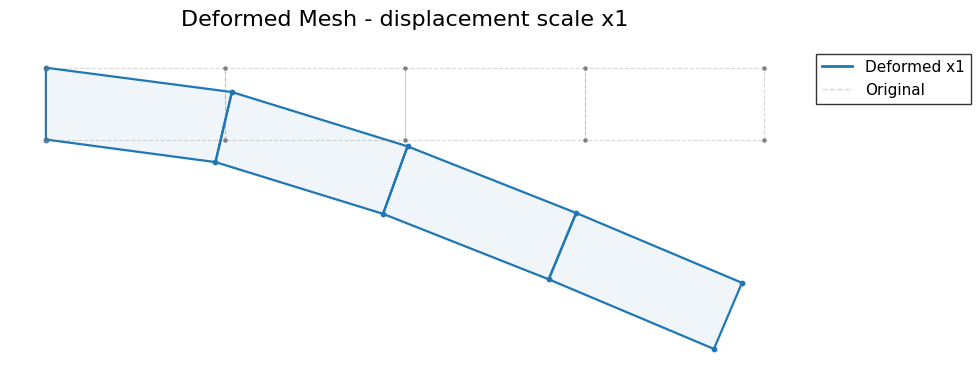

In [37]:
feinn_solver.plot_deformed_mesh(scale=1)

In [38]:
Fint_nn = feinn_solver._assemble_internal_forces(feinn_solver.udisp)
Fint_nn

tensor([ 4.3381e+04,  4.2853e+03,  6.1989e-03, -1.1250e+03, -6.3101e-03,
        -1.1250e+03, -4.4610e-03, -1.1250e+03,  1.5311e-02, -5.6251e+02,
        -4.3381e+04,  3.5897e+03,  3.1154e-03, -1.1250e+03, -1.8748e-03,
        -1.1250e+03, -1.2305e-02, -1.1250e+03,  1.1401e-02, -5.6250e+02])

In [39]:
Fint_fem

tensor([ 4.3381e+04,  4.2853e+03, -5.4570e-11, -1.1250e+03, -1.4734e-10,
        -1.1250e+03, -2.1737e-10, -1.1250e+03, -1.2257e-10, -5.6250e+02,
        -4.3381e+04,  3.5897e+03,  1.1642e-10, -1.1250e+03,  3.0923e-11,
        -1.1250e+03,  3.6471e-10, -1.1250e+03,  1.2380e-10, -5.6250e+02])

In [40]:
cantilever_fem.Fext_total

tensor([    0.0000,  -562.5000,     0.0000, -1125.0000,     0.0000, -1125.0000,
            0.0000, -1125.0000,     0.0000,  -562.5000,     0.0000,  -562.5000,
            0.0000, -1125.0000,     0.0000, -1125.0000,     0.0000, -1125.0000,
            0.0000,  -562.5000])

In [41]:
Fint_fem / Fint_nn

tensor([ 1.0000e+00,  1.0000e+00, -8.8032e-09,  1.0000e+00,  2.3350e-08,
         1.0000e+00,  4.8727e-08,  1.0000e+00, -8.0052e-09,  9.9998e-01,
         1.0000e+00,  1.0000e+00,  3.7368e-08,  1.0000e+00, -1.6494e-08,
         1.0000e+00, -2.9639e-08,  1.0000e+00,  1.0859e-08,  9.9999e-01])

In [42]:
Fint_nn[::2].sum()

tensor(-5.0022e-12)

In [43]:
Fint_fem[::2].sum()

tensor(-1.3642e-11)

In [44]:
Fint_nn[1::2].sum()

tensor(-2.2737e-12)

In [45]:
Fint_fem[1::2].sum()

tensor(-9.0949e-13)